# <center><span style = "color:DodgerBlue"> Spaceship Titanic: EDA & Feature Engineering</span></center>



# Introduction
**Objective**
* In this notebook we will focus towards conducting a thorough exploratory data analysis to understand the data and the relationship between the variables. 
* We will also perform feature engineering to create new features that are informative. 
* After that we will fit a Random Forest model to create predictions and submit.

**Problem Summary**
* We are in the year 2912 and a spaceship called Titanic started off from the Earth to emigrate about 13,000 passengers to three newly habitable exoplanets.
* Before reaching it's first destinantion it collided with a spacetime anomaly and almost half of the passengers were transported to an alternate dimension.
* Using the records recovered from the spaceship, we need to predict which passengers were transported by the anomaly.

# Table of Contents
<a id="toc"></a>
- [1. Import packages & Read data](#1)
- [2. Utility Code](#2)
- [3. Inspect the data ](#3)
- [4. Exploratory Data Analysis](#4)
    - [4.1 Transported](#4.1)
- [5. Feature Engineering](#5)    
- [6. Random Forest Model](#6)  
    - [6.1 Data Preprocessing](#6.1)
    - [6.2 Fitting a Random Forest Model](#6.2)
- [7. Submission](#7)   
- [8. References](#8)   

<a id="1"></a>
# 1. Import packages & Read data

In [1]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import category_encoders as ce
from sklearn import metrics, ensemble, model_selection, tree
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import export_graphviz

# Configs
#plt.style.use('ggplot')
%config InlineBackend.figure_format='retina'

# Read the data
df = pd.read_csv('../input/spaceship-titanic/train.csv')
train = pd.read_csv('../input/spaceship-titanic/train.csv')
test = pd.read_csv('../input/spaceship-titanic/test.csv')
ss = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')

<a id="2"></a>
# 2. Utility Code

In [2]:
# Inspect the data.
def check_features(df):
    return pd.DataFrame({'unique_values': df.nunique(),'type': df.dtypes,'pct_missing': df.isna().sum()/len(df) * 100}).sort_values(by = 'pct_missing', ascending=False) 

# Functions to fit train and evaluate a model.
def mfe(model, x_train, y_train, x_val, y_val):
    model.fit(x_train, y_train)
    preds_train = model.predict(x_train); preds_val = model.predict(x_val)
    acc_train = metrics.accuracy_score(y_train, preds_train); acc_val = metrics.accuracy_score(y_val, preds_val)
    result = pd.DataFrame({'accuray_train': acc_train, 'accuray_val': acc_val}, index=['metrics'])
    display(result)
# Function to submit. 

def submit(preds_test,fname=None):
    df_preds = pd.DataFrame({'PassengerId':test.PassengerId , 'Transported': preds_test})
    df_preds.to_csv(fname ,index=False)    

<a id="3"></a>
# 3. Inspect the data 

In [3]:
df.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


<a id="4"></a>
# 4. Exploratory Data Analysis

<a id="4.1"></a>
## 4.1 Transported
*Whether the passenger was transported to another dimension. This is the target, the column we are trying to predict.*

**Summary**

* `Transported` is the dependent variable for this problem. We need to predict which passengers were transported by the anomaly.
* There are almost similar number of people who were transported & who did not transport so there is no class imbalance in the problem.

In [5]:
df.Transported.value_counts().to_frame().T

,True,False
Transported,4378,4315


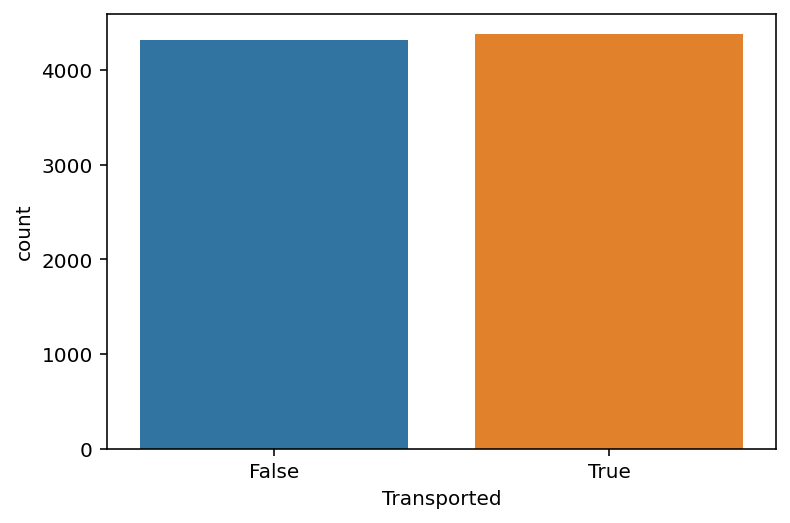

In [6]:
sns.countplot(x='Transported', data=df);

<a id="4.2"></a>
## 4.2 HomePlanet
*The planet the passenger departed from, typically their planet of permanent residence*

💡 **Summary**

* `HomePlanet` is a categorical feature with three values i.e. Earth, Europa, Mars.
* 

Q: What are the distinct values for `HomePlanet` ?

In [7]:
df.loc[:, 'HomePlanet'].value_counts().to_frame().T

,Earth,Europa,Mars
HomePlanet,4602,2131,1759


Q: How does `HomePlanet` relate to `Transported` ?

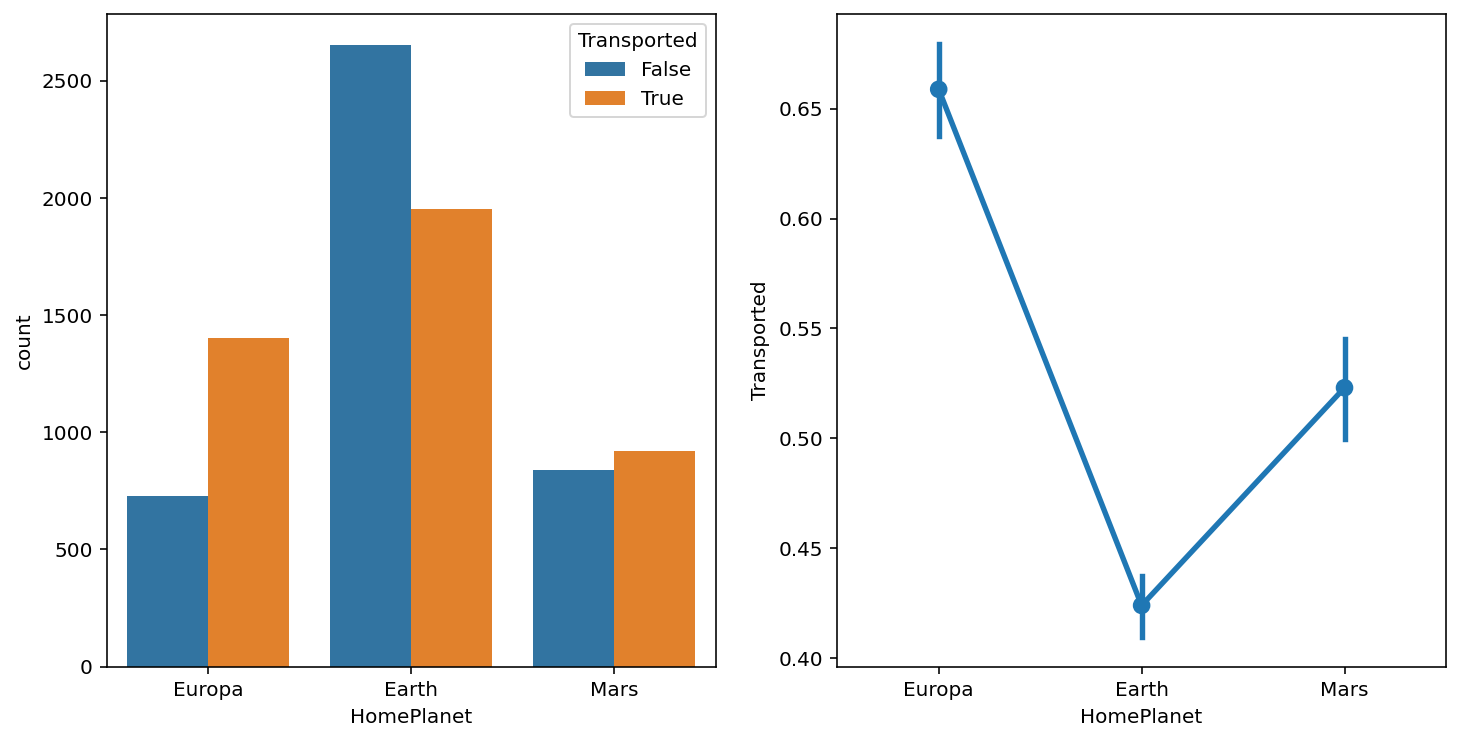

In [8]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.countplot(x='HomePlanet', hue='Transported', data=df, ax=ax[0])
sns.pointplot(x='HomePlanet', y='Transported', data=df, ax=ax[1]);


In [9]:
pd.crosstab(index=df.HomePlanet, columns=df.Transported, values=df.PassengerId, aggfunc='count', normalize=0)

Transported,False,True
HomePlanet,,
Earth,0.576054,0.423946
Europa,0.341154,0.658846
Mars,0.476976,0.523024


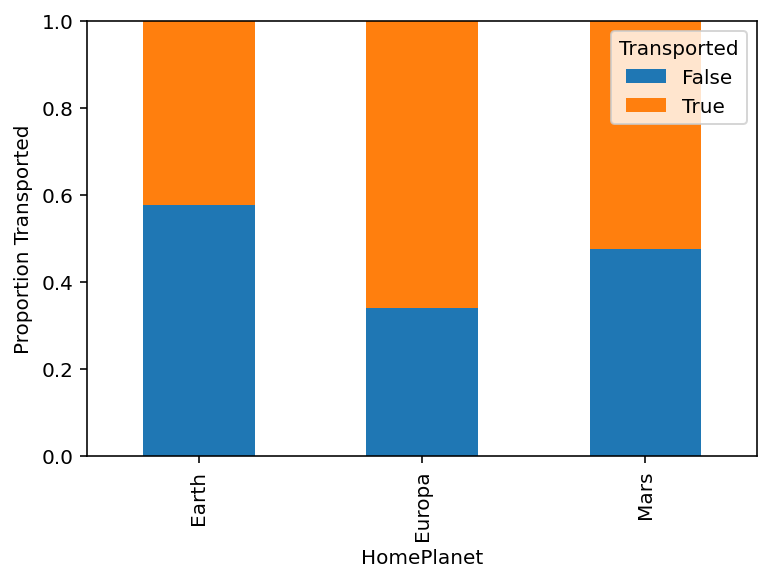

In [10]:
pd.crosstab(index=df.HomePlanet, columns=df.Transported, values=df.PassengerId, aggfunc='count', normalize=0).plot(kind='bar', stacked=True, ylim=(0,1), ylabel='Proportion Transported');

The probability of being transported based on the HomePlanet is in the following order `Europa` > `Mars` > `Earth`

<a id="4.3"></a>
## 4.3 CryoSleep
*Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.*

Q: What are the distinct values for `CryoSleep` ?

In [11]:
df.CryoSleep.value_counts().to_frame().T

,False,True
CryoSleep,5439,3037


Q: How does `CryoSleep` relate to `Transported` ?

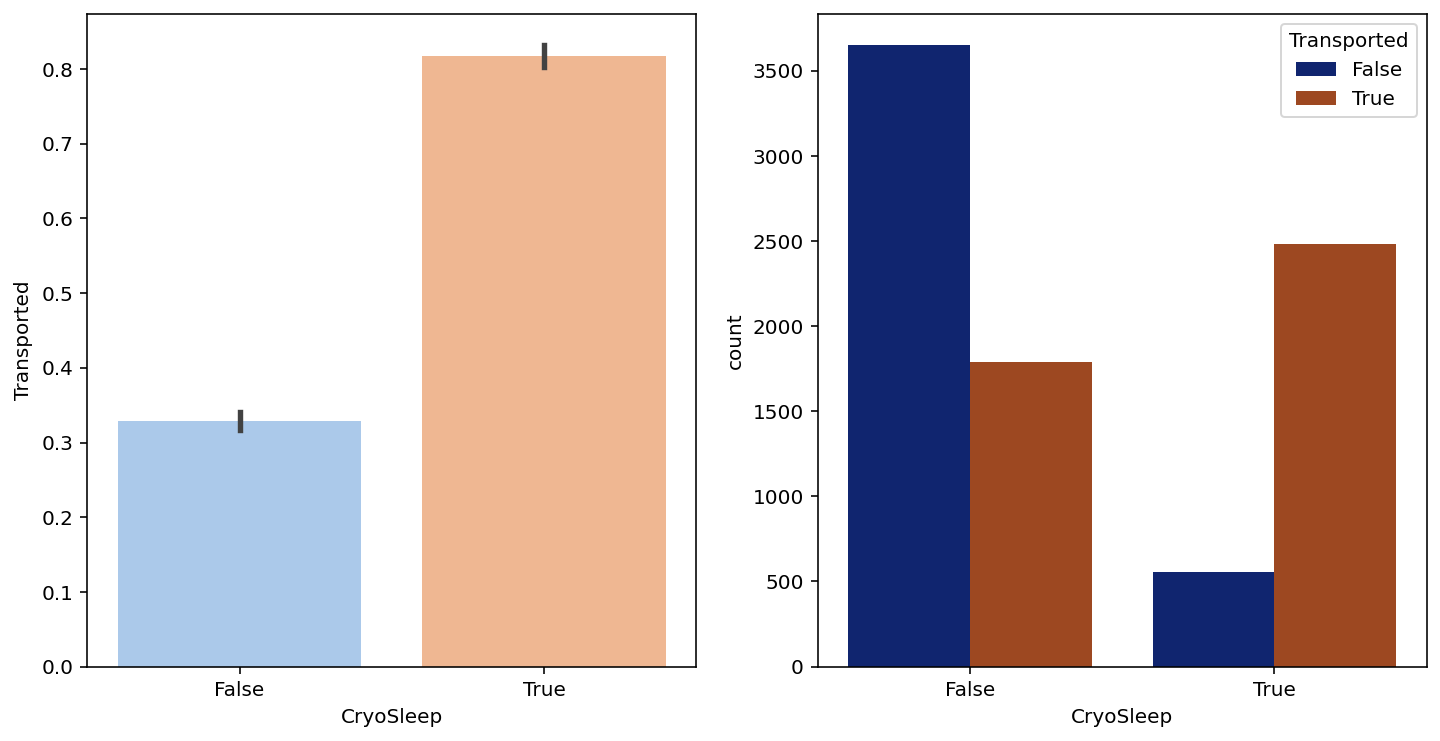

In [12]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.barplot(x='CryoSleep', y='Transported', data=df, palette='pastel', ax=ax[0]);
sns.countplot(x='CryoSleep', hue='Transported', data=df, palette='dark', ax=ax[1]);

In [13]:
pd.crosstab(index=df.CryoSleep, columns=df.Transported,  margins=True, normalize=True)

Transported,False,True,All
CryoSleep,,,
False,0.430628,0.211067,0.641694
True,0.065361,0.292945,0.358306
All,0.495989,0.504011,1.000000


`CryoSleep` is a strong feature. There is a high likelihood of being transported when cryosleep is True.

## 4.4 Cabin
*The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.*

Q: What are the unique values of Cabin feature?

In [14]:
df.Cabin.nunique()

6560

Q: How does the Cabin Feature look like?

In [15]:
df.Cabin.head(2).to_frame()

,Cabin
0,B/0/P
1,F/0/S


Let's split the feature on "/" and create three new columns.

In [16]:
df = df.join(df['Cabin'].str.split('/', expand=True).rename(columns={0:'deck', 1:'num', 2:'side'}))

In [17]:
df.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S


## 4.5 Destination
*The planet the passenger will be debarking to.*

Q: What are the different values for Destination feature?

In [18]:
df.Destination.value_counts().to_frame().T

,TRAPPIST-1e,55 Cancri e,PSO J318.5-22
Destination,5915,1800,796


Q: How does `Destination` relate to `Transported` ?

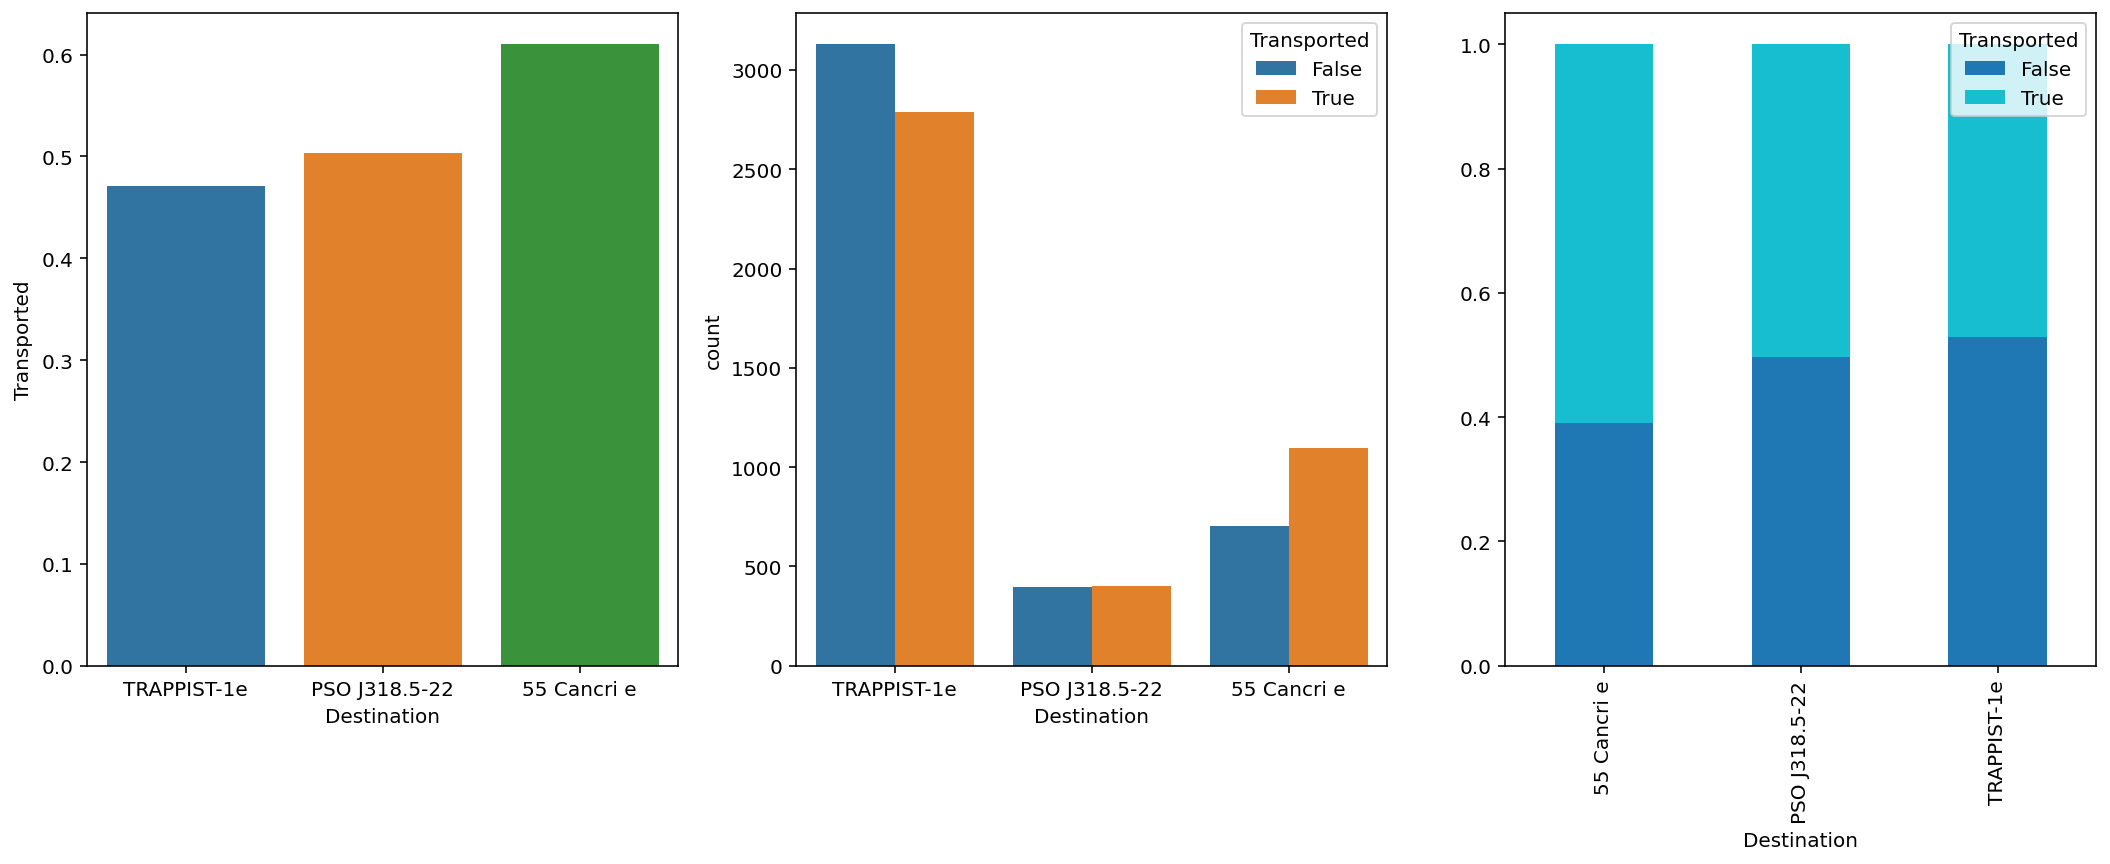

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(18,6))
sns.barplot(x='Destination', y='Transported', data=df, ci=None, ax=ax[0]); 
sns.countplot(x='Destination', hue='Transported', data=df, ax=ax[1]);
(pd
 .crosstab(index=df.Destination, columns=df.Transported, values=df.PassengerId, aggfunc='count', normalize='index')
 .plot(kind='bar', stacked=True, colormap='tab10', ax=ax[2])
);

People going to Cancri have the highest probability of being transported. The order is Cancri > PSOJ > Trappist.

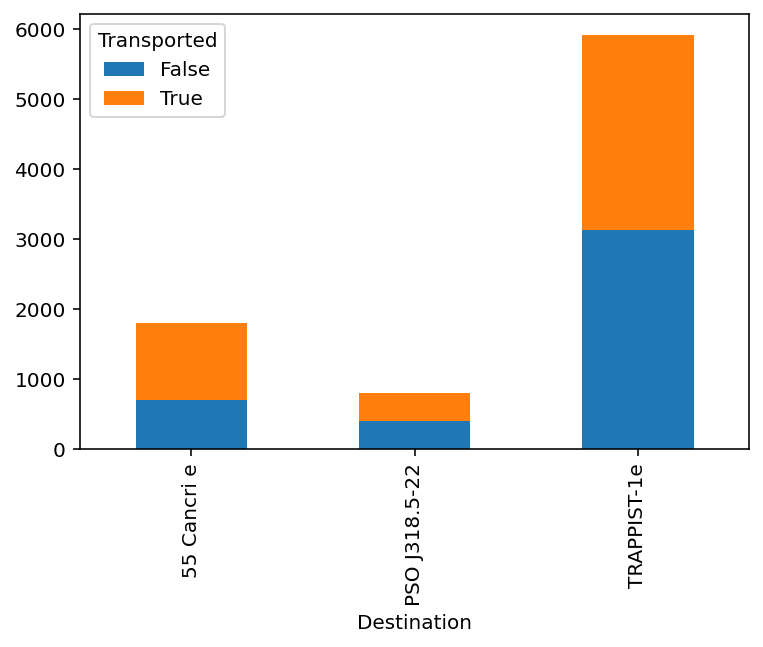

In [20]:
# Stacker bar plot using pandas
(df
  .groupby(['Destination', 'Transported'])['PassengerId'].agg('count').to_frame()
  .reset_index()
  .pivot(index='Destination', columns='Transported', values='PassengerId')
  .plot.bar(stacked=True) 
);

## 4.6 Age
*The age of the passenger.*

* Q: What does the distribution of `Age` look like? Is it skewed?
* Q: Are there any outliers?
* Q: How does `Age` relate to `Transported`?

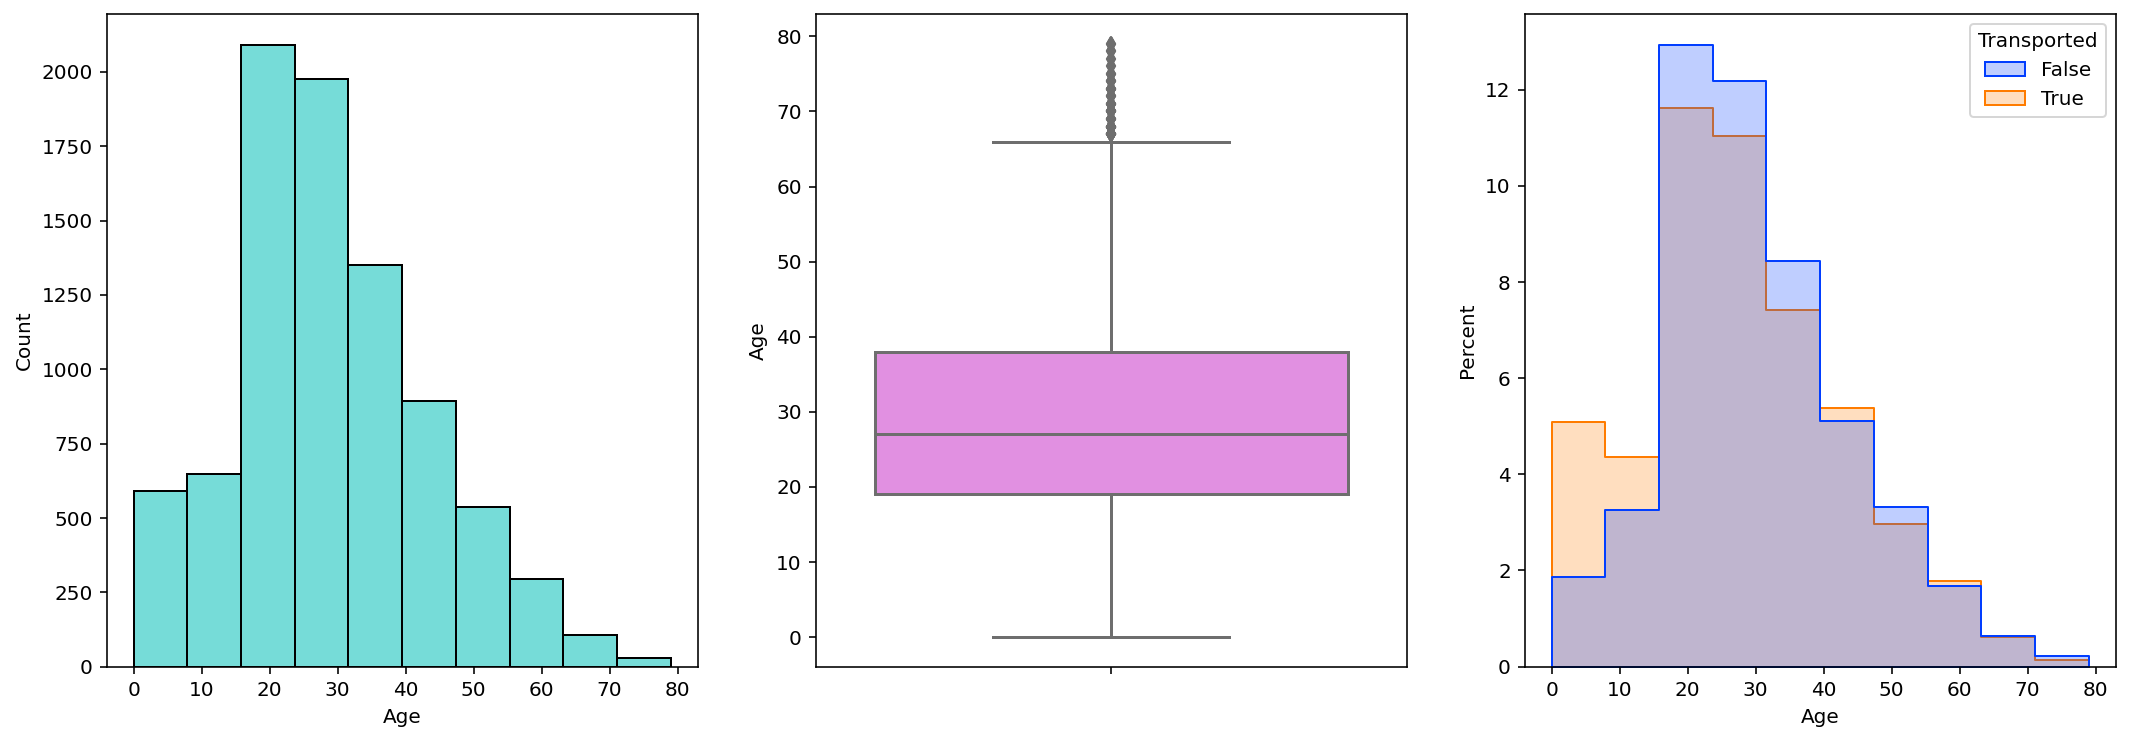

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(18,6))
sns.histplot(x='Age', data=df, bins=10, color='mediumturquoise', ax=ax[0]);
sns.boxplot(y='Age', data=df, color='violet', ax=ax[1]);
sns.histplot(x='Age', hue='Transported', data=df, stat='percent',bins=10, element='step', palette='bright',ax=ax[2]);

## 4.7 VIP
*Whether the passenger has paid for special VIP service during the voyage.*

In [22]:
df.VIP.value_counts().to_frame().T

,False,True
VIP,8291,199


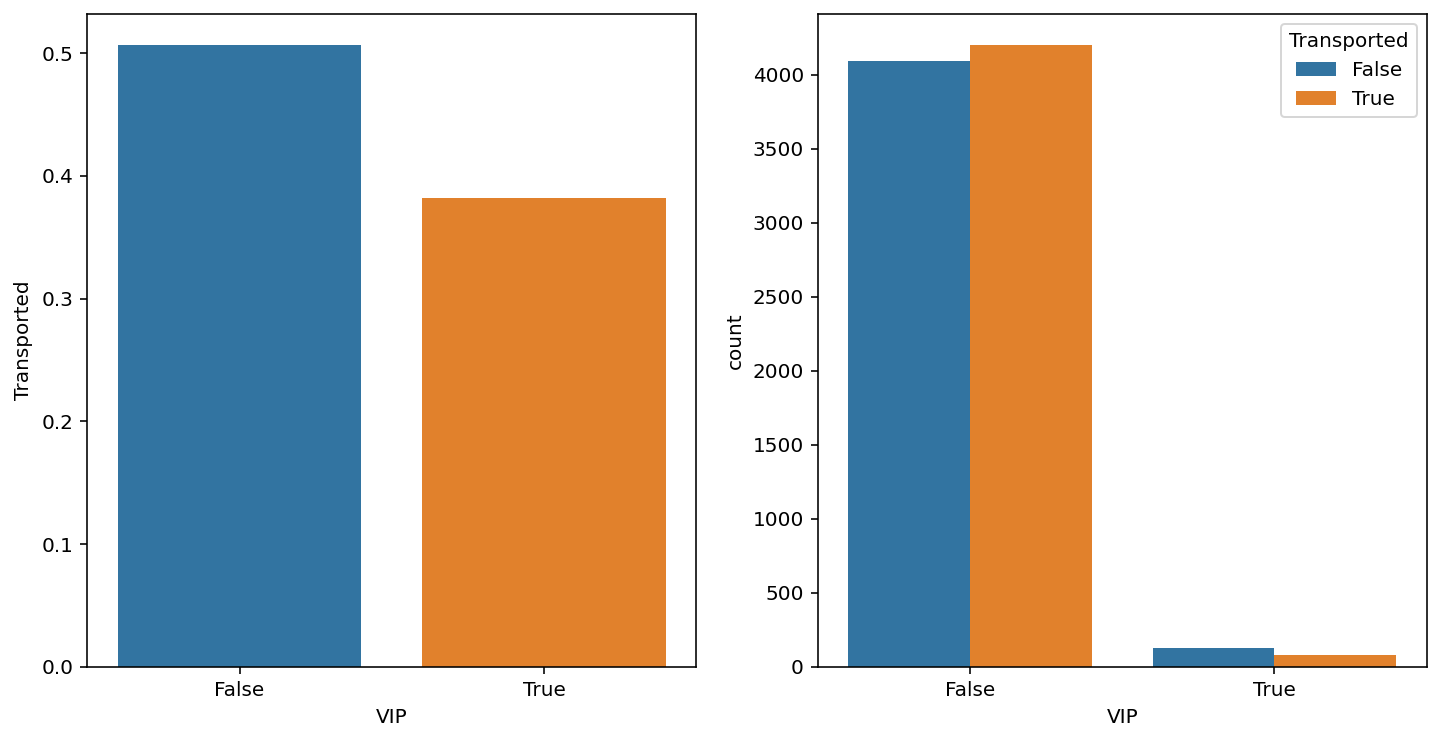

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
sns.barplot(x='VIP', y='Transported', data=df, ci=None, ax=ax[0]);
sns.countplot(x='VIP', hue='Transported', data=df, ax=ax[1]);

In [24]:
df.groupby('Transported')['VIP'].agg('count').to_frame()

,VIP
Transported,
False,4216
True,4274


## 4.8 RoomService
*Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.*

In [25]:
df = df.assign(room_serv_log = np.log1p(df.RoomService))

In [26]:
df.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side,room_serv_log
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P,0.00000
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S,4.70048


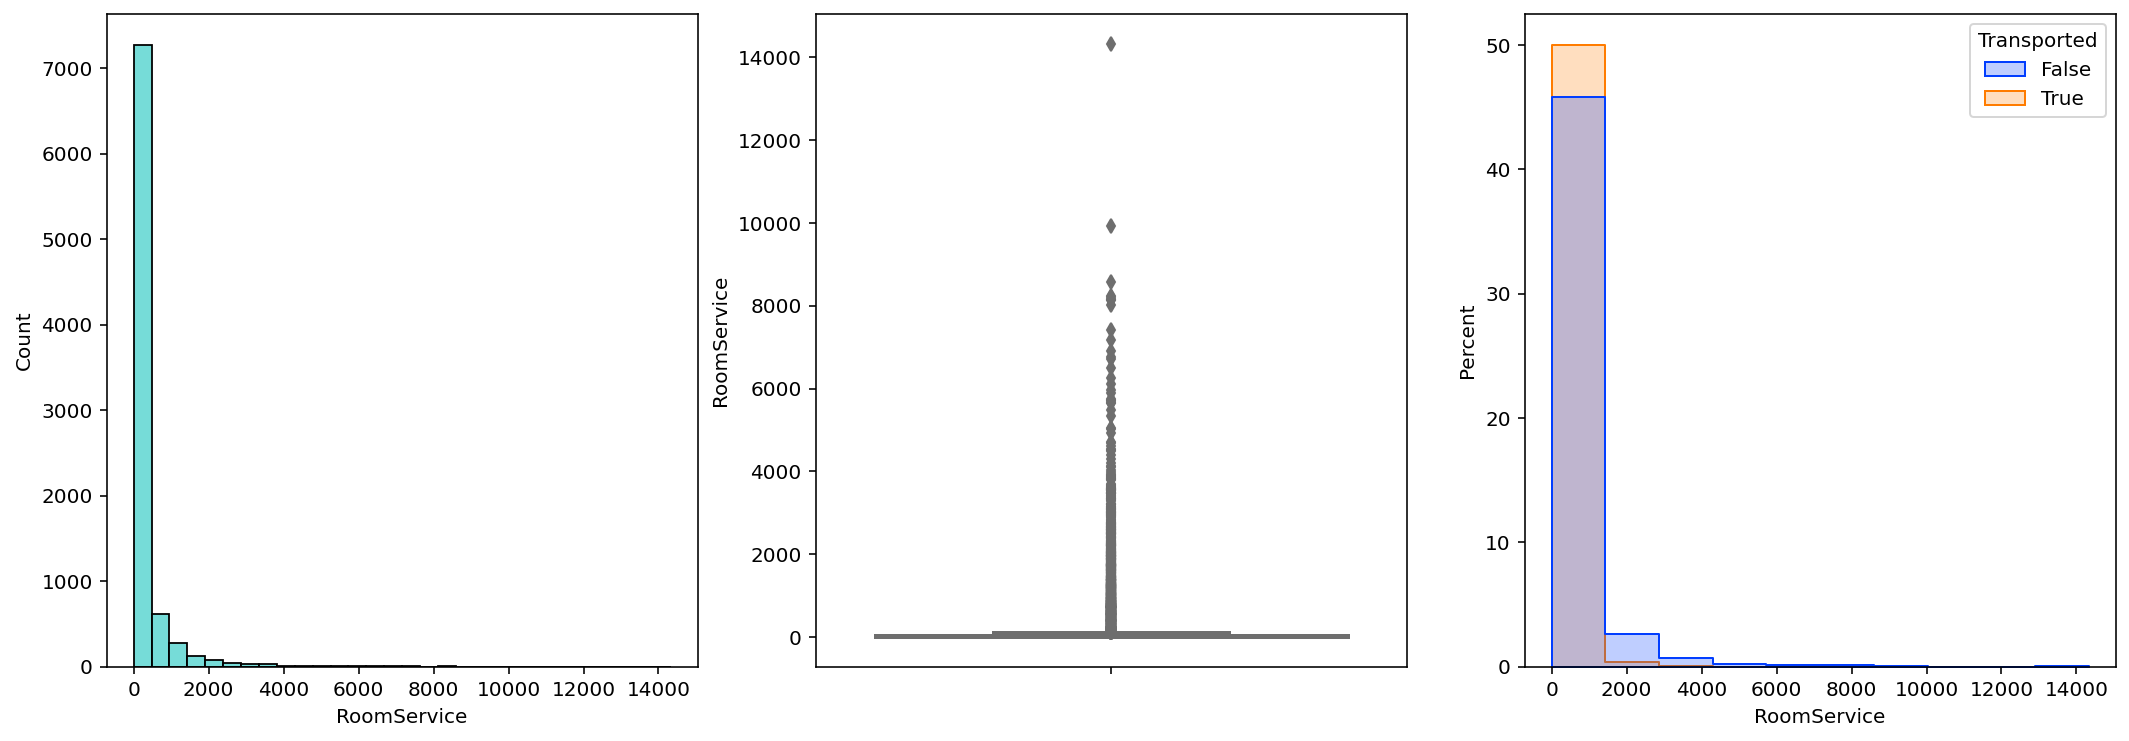

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(18,6))
sns.histplot(x='RoomService', data=df, bins=30, color='mediumturquoise', ax=ax[0]);
sns.boxplot(y='RoomService', data=df, color='violet', ax=ax[1]);
sns.histplot(x='RoomService', hue='Transported', data=df, stat='percent',bins=10, element='step', palette='bright',ax=ax[2]);

## 4.9 Food Court 
*Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.*

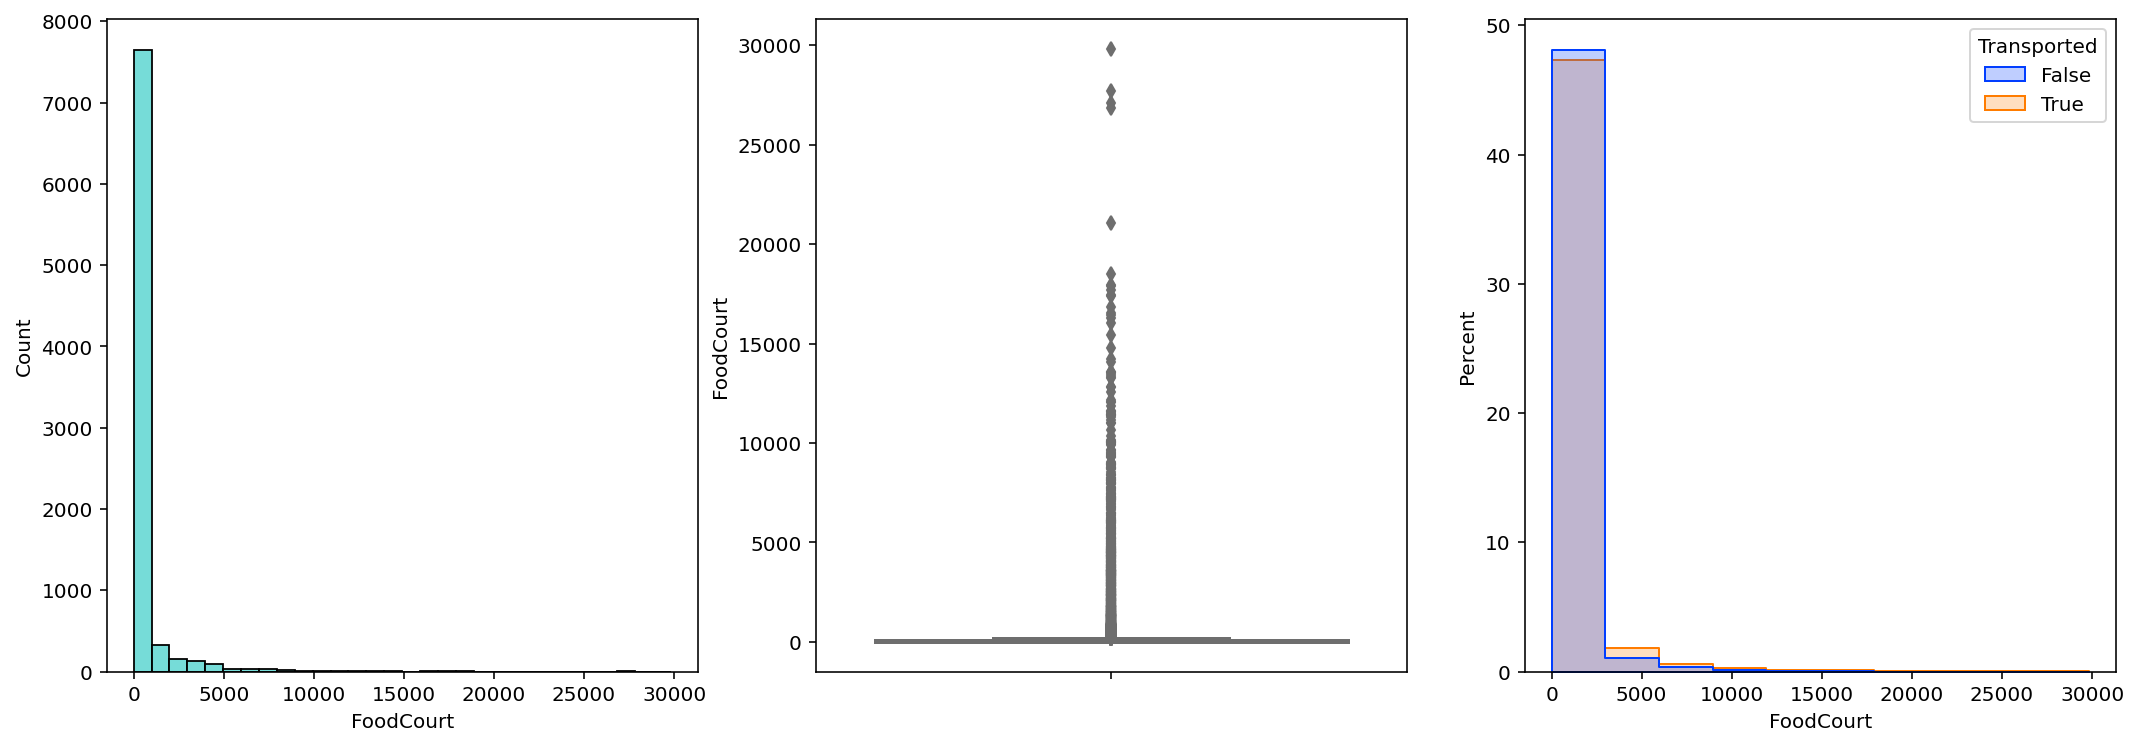

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(18,6))
sns.histplot(x='FoodCourt', data=df, bins=30, color='mediumturquoise', ax=ax[0]);
sns.boxplot(y='FoodCourt', data=df, color='violet', ax=ax[1]);
sns.histplot(x='FoodCourt', hue='Transported', data=df, stat='percent',bins=10, element='step', palette='bright',ax=ax[2]);

In [29]:
df = df.assign(food_court_log = np.log1p(df.FoodCourt))
df.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side,room_serv_log,food_court_log
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P,0.00000,0.000000
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S,4.70048,2.302585


## 4.10 ShoppingMall
*Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.*

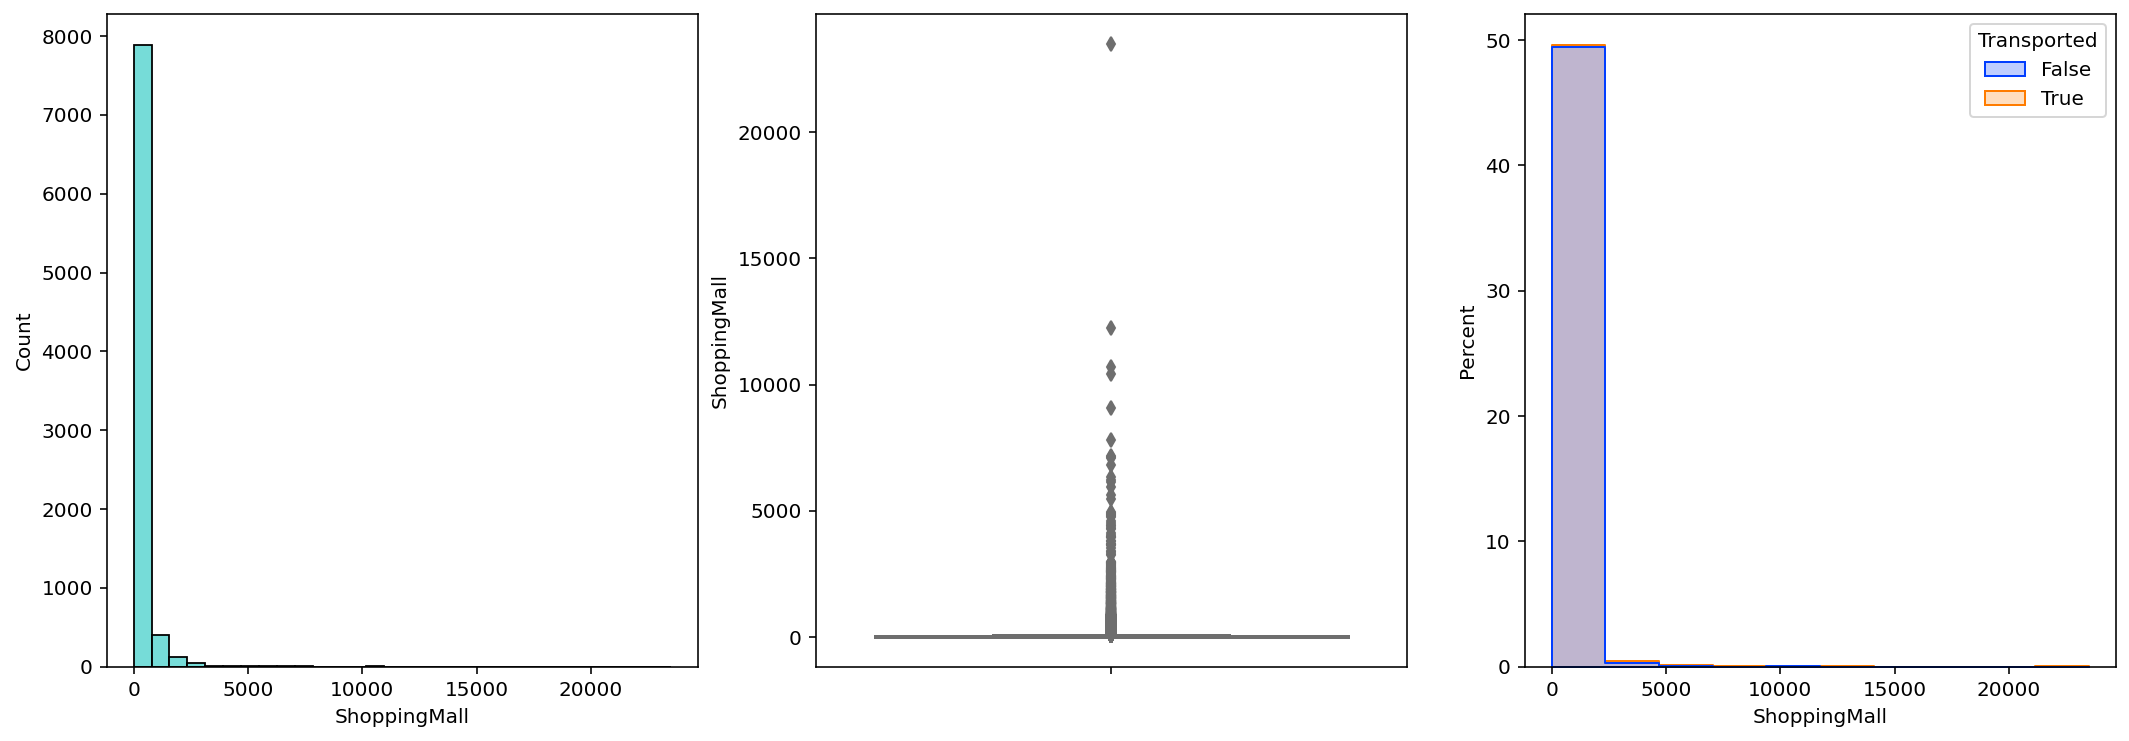

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(18,6))
sns.histplot(x='ShoppingMall', data=df, bins=30, color='mediumturquoise', ax=ax[0]);
sns.boxplot(y='ShoppingMall', data=df, color='violet', ax=ax[1]);
sns.histplot(x='ShoppingMall', hue='Transported', data=df, stat='percent',bins=10, element='step', palette='bright',ax=ax[2]);

## 4.11 Spa
*Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.*

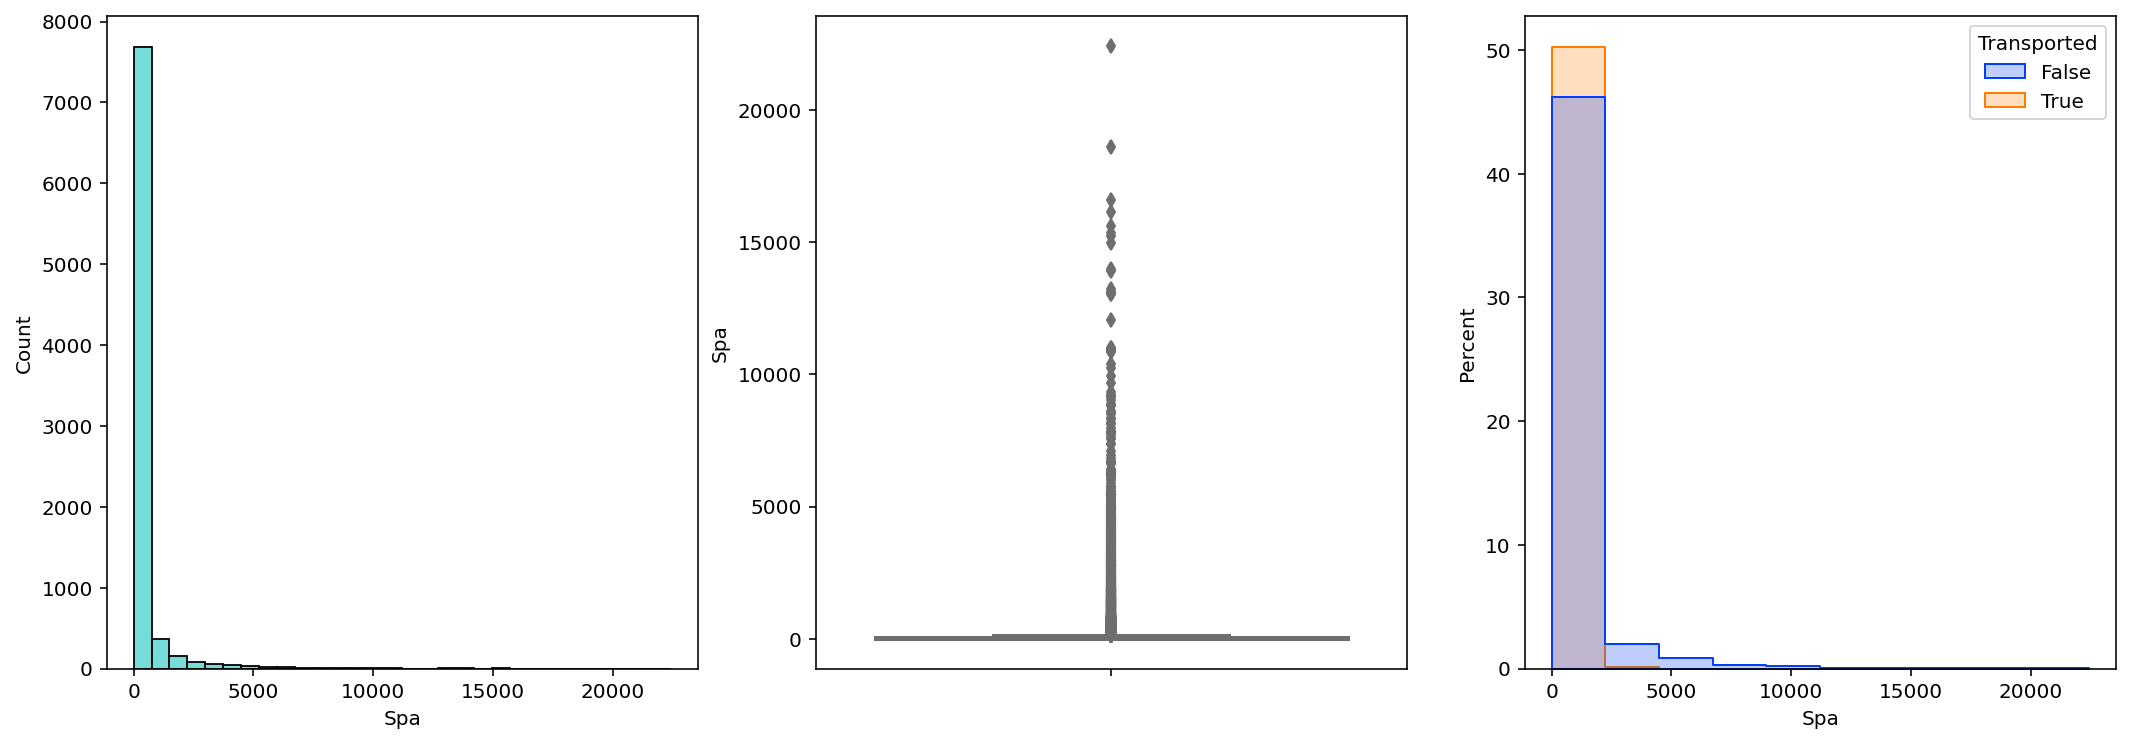

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(18,6))
sns.histplot(x='Spa', data=df, bins=30, color='mediumturquoise', ax=ax[0]);
sns.boxplot(y='Spa', data=df, color='violet', ax=ax[1]);
sns.histplot(x='Spa', hue='Transported', data=df, stat='percent',bins=10, element='step', palette='bright',ax=ax[2]);

## 4.12 VRDeck
*Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.*

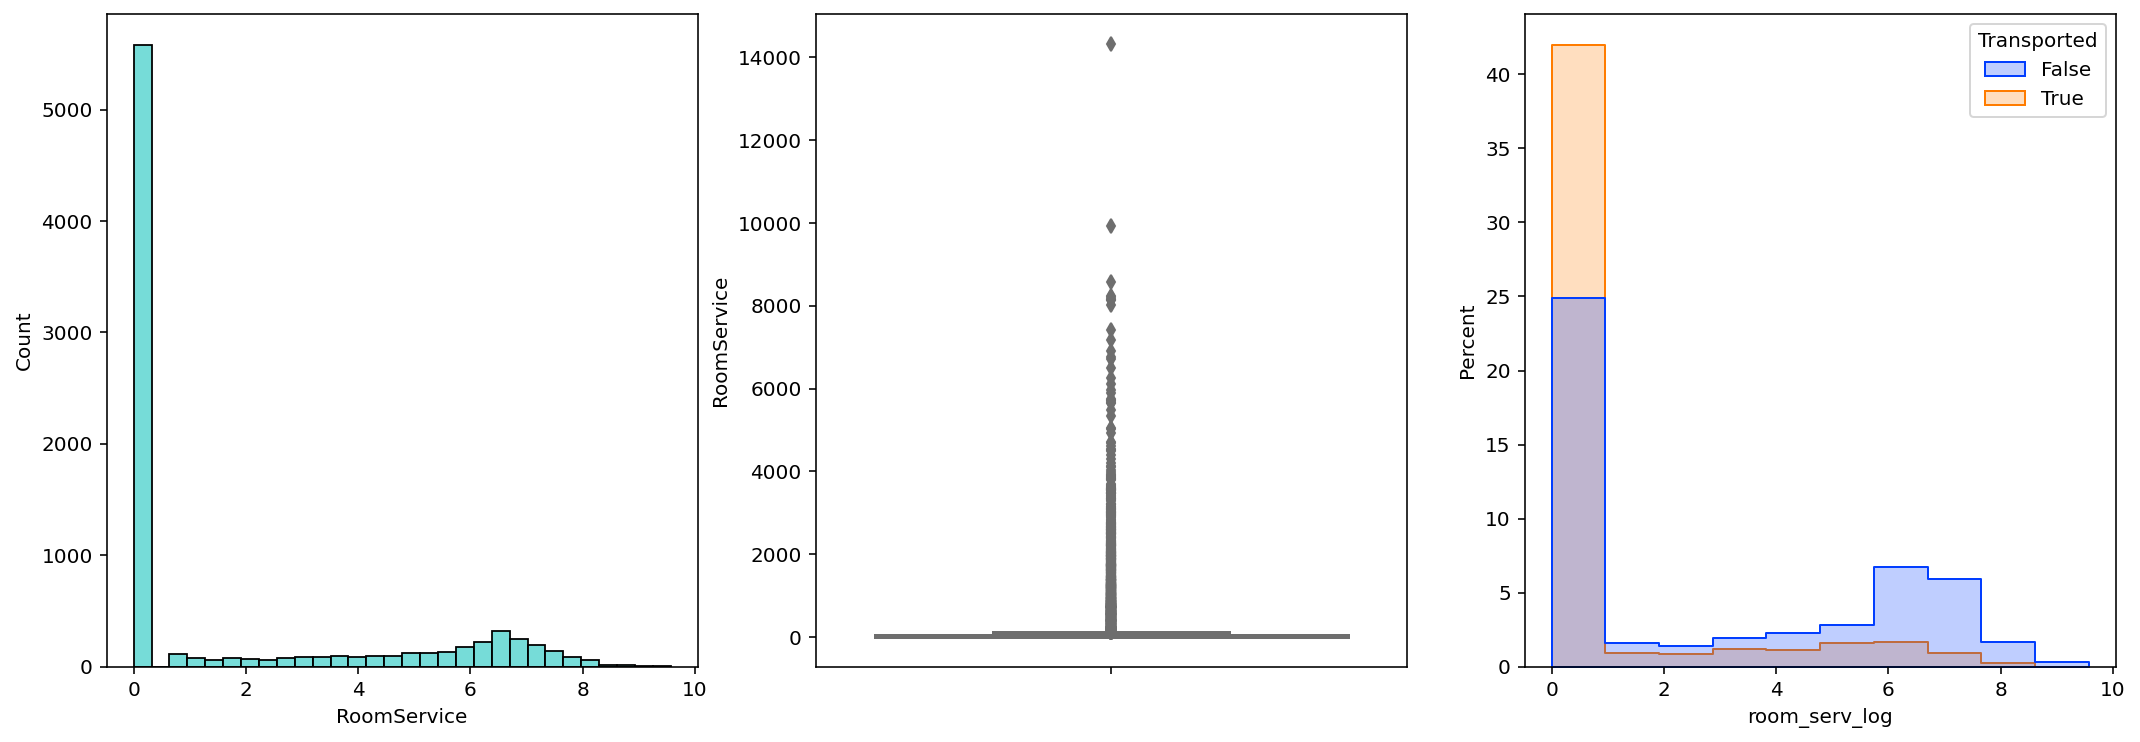

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(18,6))
sns.histplot(x=np.log1p(df.RoomService) , data=df, bins=30, color='mediumturquoise', ax=ax[0]);
sns.boxplot(y='RoomService', data=df, color='violet', ax=ax[1]);
sns.histplot(x='room_serv_log', hue='Transported', data=df, stat='percent',bins=10, element='step', palette='bright',ax=ax[2]);

## 4.13 Name
*The first and last names of the passenger.*

## 4.14 PassengerId
*A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always*

In [33]:
df.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side,room_serv_log,food_court_log
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P,0.00000,0.000000
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S,4.70048,2.302585


In [34]:
df_psg = df.PassengerId.str.split(pat='_', expand=True).rename(columns={0: 'psg_grp', 1:'psg_num'})
df = df.join(df_psg)

In [35]:
df.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,deck,num,side,room_serv_log,food_court_log,psg_grp,psg_num
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,False,B,0,P,0.00000,0.000000,0001,01
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,True,F,0,S,4.70048,2.302585,0002,01


In [36]:
df.psg_grp.nunique()

6217

In [37]:
df.psg_num.nunique()

8

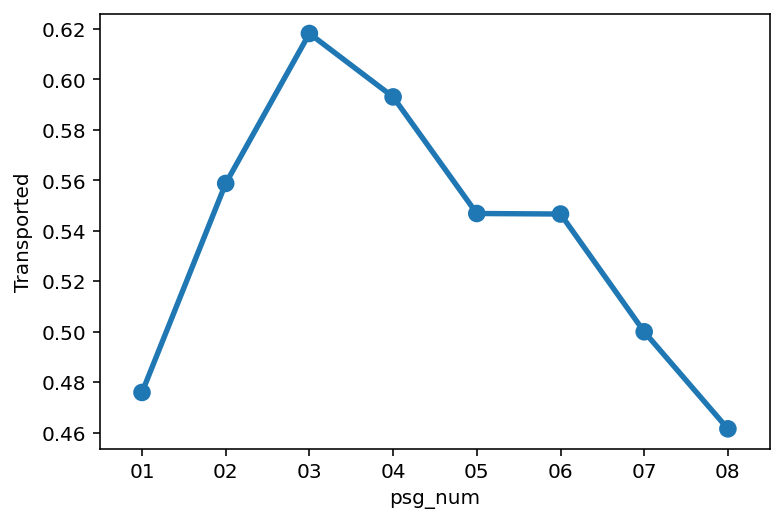

In [38]:
sns.pointplot(x='psg_num', y='Transported', data=df, ci=None);

## 4.15 Spending

In [39]:
df = df.assign(
    lux_spend = df.RoomService + df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck,
    no_spend = np.where((df.RoomService + df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck) == 0, 'Yes', 'No')
)

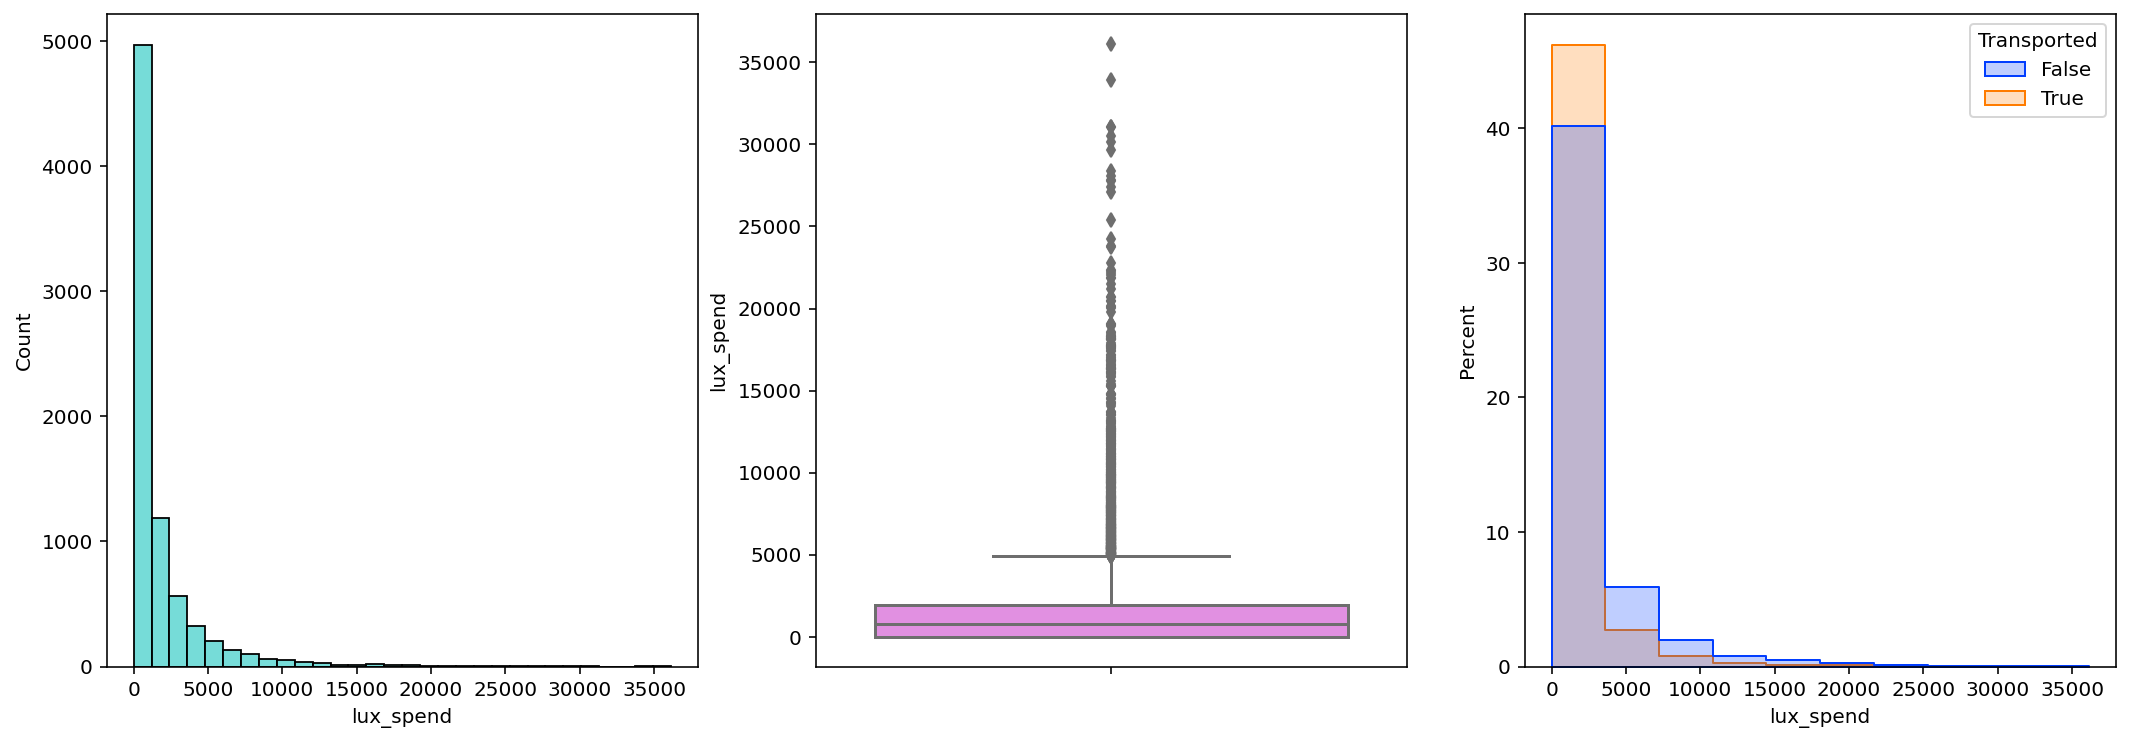

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(18,6))
sns.histplot(x='lux_spend', data=df, bins=30, color='mediumturquoise', ax=ax[0]);
sns.boxplot(y='lux_spend', data=df, color='violet', ax=ax[1]);
sns.histplot(x='lux_spend', hue='Transported', data=df, stat='percent',bins=10, element='step', palette='bright',ax=ax[2]);

In [41]:
df.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,deck,num,side,room_serv_log,food_court_log,psg_grp,psg_num,lux_spend,no_spend
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,False,B,0,P,0.00000,0.000000,0001,01,0.0,Yes
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,True,F,0,S,4.70048,2.302585,0002,01,845.0,No


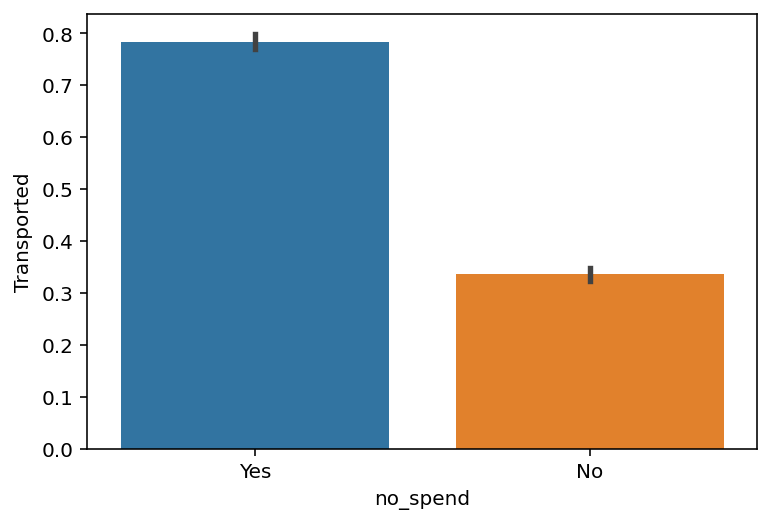

In [42]:
sns.barplot(x='no_spend', y='Transported', data=df);

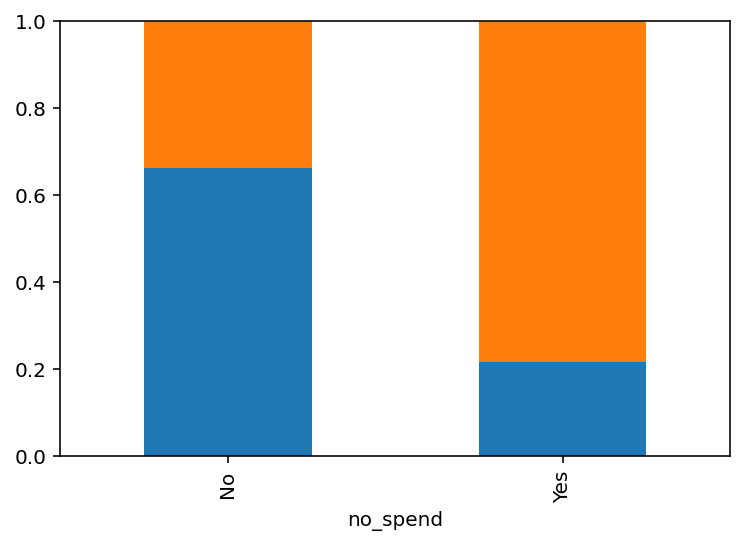

In [43]:
(pd
 .crosstab(index=df.no_spend, columns=df.Transported, values=df.PassengerId, aggfunc='count', normalize='index')
 .plot(kind='bar', stacked=True, legend=False, ylim=(0,1))
);

<a id="5"></a>
# 5. Feature Engineering

In [44]:
def feat_engg(df):
    df = df.join(df['Cabin'].str.split('/', expand=True).rename(columns={0:'deck', 1:'num', 2:'side'}))
    df = df.join(df.PassengerId.str.split(pat='_', expand=True).rename(columns={0: 'psg_grp', 1:'psg_num'}))
    df = df.assign(
       lux_spend = df.RoomService + df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck,
       no_spend = np.where((df.RoomService + df.RoomService + df.FoodCourt + df.ShoppingMall + df.Spa + df.VRDeck) == 0, 'Yes', 'No')
    )
    return df

In [45]:
train = feat_engg(train)
test = feat_engg(test)

<a id="6"></a>
# 6. Random Forest Model


## 6.1 Data Preprocessing

In [46]:
# Define feature types.
target = ['Transported']
cat_feats = train.drop(columns=['PassengerId', 'Transported', 'Name', 'Cabin', 'psg_grp']).select_dtypes(include='object').columns.tolist()
cont_feats = train.drop(columns=['PassengerId', 'Transported', 'Name', 'Cabin', 'psg_grp']).select_dtypes(include=np.number).columns.tolist()
all_feats = cat_feats + cont_feats
len(train.columns), len(cat_feats), len(cont_feats)

(21, 9, 7)

In [47]:
# Pipeline for categorical feature transformation.
cat_tfms = Pipeline(steps=[
    ('cat_ordenc', ce.OrdinalEncoder(return_df=True, handle_unknown='value', handle_missing='value'))
])

# Pipeline for numeric feature transformation.
cont_tfms = Pipeline(steps=[
    ('cont_imputer', SimpleImputer(missing_values=np.nan, strategy='median'))
])

# Transform cat & cont features separately and concatenate the features.
ctf = ColumnTransformer(transformers=[
    ('cat_tfms', cat_tfms, cat_feats),
    ('cont_tfms', cont_tfms, cont_feats)
], remainder='passthrough')

In [48]:
# Transform the data.
X = train[all_feats]
y = train.Transported.astype(int)

# Split the data.
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=.2, shuffle=True, random_state=42)

# Transform the train, valid & test sets.
x_train_tf = pd.DataFrame(ctf.fit_transform(x_train), columns=all_feats)
x_val_tf = pd.DataFrame(ctf.transform(x_val), columns=all_feats)
x_test_tf = pd.DataFrame(ctf.transform(test[all_feats]), columns=all_feats)

In [49]:
# Map the categorical features to encodings.
# ordenc_map = dict()
# for feat in cat_feats: ordenc_map[feat] = dict(zip(x_train[feat], x_train_tf[feat]))

## 6.2 Fitting a Random Forest Model¶

In [50]:
# Define a random forest model.
rf1 = RandomForestClassifier(n_estimators=40, max_depth=6, min_samples_leaf=1, min_samples_split=2,max_features=None, 
                             max_samples=None, n_jobs=-1, random_state=1)

# Call the utility function for model fitting & evaluation.
mfe(rf1, x_train_tf, y_train, x_val_tf, y_val)

,accuray_train,accuray_val
metrics,0.815933,0.791259


<a id="7"></a>
# 7. Submission

In [51]:
preds_test = rf1.predict(x_test_tf)
preds_test = preds_test.astype(bool)
df_preds = pd.DataFrame({'PassengerId': test.PassengerId , 'Transported': preds_test})
df_preds.to_csv('sub8.csv' ,index=False)    

In [52]:
# import json
# !mkdir ~/.kaggle
# !touch ~/.kaggle/kaggle.json
# api_token = {"username":"adityabhat","key":"077eab99785d783113fedbf2698bcc53"}
# with open('/root/.kaggle/kaggle.json', 'w') as file:
#     json.dump(api_token, file)
# !chmod 600 ~/.kaggle/kaggle.json

In [53]:
#!kaggle competitions submit -c spaceship-titanic -f sub4.csv -m "RF1"

<a id="8"></a>
# 8. References

* [1](https://www.coursera.org/learn/competitive-data-science/lecture/zoIx3/visualizations)
* [Formatting](https://www.kaggle.com/code/adityabhat/spaceship-titanic-eda-27-different-models/edit)
* [Shortcuts](https://towardsdatascience.com/jypyter-notebook-shortcuts-bf0101a98330)